# Estimating Stellar Mass-to-Light Ratios using Colours

Based on the work by [Taylor et al. (2011)](https://academic.oup.com/mnras/article/418/3/1587/1060932) and maybe [Gallazzi & Bell (2009)](https://iopscience.iop.org/article/10.1088/0067-0049/185/2/253)


In [1]:
# May need to do this if running remote server with VS Code
%cd "/arc/home/IsaacCheng/coop_f2021/warmup"

/arc/home/IsaacCheng/coop_f2021/warmup


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.colors import LogNorm, to_rgba
from astropy.wcs import WCS
import astropy.units as u
import fits_plot_utils as utils
import dill
from scipy.optimize import curve_fit
from scipy.stats import spearmanr, pearsonr
import scipy.odr as odr
from astropy.wcs.utils import proj_plane_pixel_scales
from ltsfit.lts_linefit import lts_linefit
# import matplotlib
# print(matplotlib.__version__)

# Load and mask data


In [4]:
co_type = "nyquist"  # "9as" or "nyquist"
version = f"reproject_interp+masked_star2_{co_type}"
# 
# Load binned data from pickle file
# 
g_infile = f"/arc/home/IsaacCheng/coop_f2021/binned_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184_BINNED_{version}.pkl"
with open(g_infile, "rb") as f:
    g_file = dill.load(f)
    vcc792_dist_pc = g_file["dist_pc"]
    vcc792_dist_err_pc = g_file["dist_pc_err"]
    g_xs = g_file["x_coords"]
    g_ys = g_file["y_coords"]
    g_signal = g_file["signal_binned"]
    g_noise = g_file["noise_binned"]
    g_abs_mag = g_file["abs_mag"]
    g_abs_mag_err_withDistErr = g_file["abs_mag_err_withDistErr"]
    g_abs_mag_err_noDistErr = g_file["abs_mag_err_noDistErr"]
    g_isgood = g_file["is_good"]
    g_wcs = g_file["wcs_binned"]
    g_wcs.array_shape = g_file["wcs_binned_array_shape"]
# 
i_infile = f"/arc/home/IsaacCheng/coop_f2021/binned_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184_BINNED_{version}.pkl"
with open(i_infile, "rb") as f:
    i_file = dill.load(f)
    i_xs = i_file["x_coords"]
    i_ys = i_file["y_coords"]
    i_signal = i_file["signal_binned"]
    i_noise = i_file["noise_binned"]
    i_abs_mag = i_file["abs_mag"]
    i_abs_mag_err_withDistErr = i_file["abs_mag_err_withDistErr"]
    i_abs_mag_err_noDistErr = i_file["abs_mag_err_noDistErr"]
    i_isgood = i_file["is_good"]
    i_wcs = i_file["wcs_binned"]
    i_wcs.array_shape = i_file["wcs_binned_array_shape"]
# 
# Load CO map data
#
if co_type == "9as": 
    co_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Msolpc-2.fits"  # 9 arcsec
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # 9 arcsec
elif co_type == "nyquist":
    co_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_Msolpc-2.fits"  # Nyquist
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # Nyquist
else:
    raise ValueError("co_type must be '9as' or 'nyquist'")
data_co, header_co = utils.load_img(co_path)
unc_co, _ = utils.load_img(co_unc_path)
wcs_co = WCS(header_co)
# Convert uncertainty from K.km/s to M_sun/pc^2
alpha_co = 4.35  # M_sun/pc^2 per K.km/s
R_21 = 0.8  # dimensionless, ratio of CO(2-1) to CO(1-0)
# Apply Eq. (7) of Brown et al. (2021)
unc_co_noDistErr = alpha_co / R_21 * unc_co
print("USING", co_type, "CO DATA")

Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_Msolpc-2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   (42, 42)   float64   
Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   (42, 42)   float64   
USING nyquist CO DATA


In [5]:
gi_signal = -2.5 * np.log10(g_signal / i_signal)  # g- & i-values from binned data
gi_noise = utils.calc_colour_err(g_signal, i_signal, g_noise, i_noise)
# 
def calc_pixel_size(imgwcs, dist, dist_err=None):
    """
    Calculates the physical size of each pixel in parsecs per pixel dimension.
    
    Parameters:
      imgwcs :: `astropy.wcs.wcs.WCS`
        The WCS coordinates of the .fits file
      dist :: `astropy.units.quantity.Quantity` scalar 
        The distance to the object
      dist_err :: `astropy.units.quantity.Quantity` scalar (optional, default: None)
        The uncertainty in the distance to the object

    Returns: pc_per_px, pc_per_px_err
      pc_per_px :: some astropy quantity
        The spatial resolution of the image in parsecs per pixel (along each axis)
      pc_per_px_err :: some astropy quantity
        The uncertainty in the spatial resolution of the image (along each axis)
    """
    arcsec_per_px = (proj_plane_pixel_scales(imgwcs.celestial) * u.deg).to(u.arcsec)
    # Still deciding whether to use arctan for the next line
    arcsec_per_pc = np.rad2deg(1 * u.pc / dist.to(u.pc) * u.rad).to(u.arcsec)
    pc_per_px = arcsec_per_px / arcsec_per_pc
    # 
    if dist_err is not None:
        # arcsec_per_pc_err = np.rad2deg(1 * u.pc / dist_err.to(u.pc) * u.rad).to(u.arcsec)
        # pc_per_px_err = arcsec_per_px / arcsec_per_pc_err
        # Uncertainty transforms linearly
        pc_per_px_err = pc_per_px * dist_err.to(u.pc) / dist.to(u.pc)
        return pc_per_px, pc_per_px_err
    return pc_per_px, None
#
# Get absolute magnitudes in i-band
#
# abs_mag_i, abs_mag_i_err_withDistErr = utils.calc_mag(
#     i_signal,
#     i_noise,
#     zpt=30,
#     calc_abs=True,
#     dist=vcc792_dist_pc,
#     dist_err=vcc792_dist_err_pc,
# )
# _, abs_mag_i_err_noDistErr = utils.calc_mag(
#     i_signal,
#     i_noise,
#     zpt=30,
#     calc_abs=True,
#     dist=vcc792_dist_pc,
#     dist_err=0,
# )
i_abs_mag_sun = 4.58  # absolute AB magnitude of Sun in i-band
#
# Eq. (7) of Taylor et al. (2011)
#
log_MLi = -0.68 + 0.70 * gi_signal  # log10 of mass-to-light ratio in i-band
log_MLi_err = 0.7 * gi_noise  # uncertainty in log10 of mass-to-light ratio
MLi = 10 ** log_MLi  # mass-to-light ratio in i-band
MLi_err = np.log(10) * abs(MLi * log_MLi_err)  # uncertainty in mass-to-light ratio
#
# Get masses in solar units
#
Li = 10 ** (-0.4 * (i_abs_mag - i_abs_mag_sun))  # luminosity in i-band
Li_err_noDistErr = abs(
    Li * np.log(10) * 0.4 * i_abs_mag_err_noDistErr
)  # uncertainty in luminosity, assuming no error in abs_mag_i_sun
Li_err_withDistErr = abs(
    Li * np.log(10) * 0.4 * i_abs_mag_err_withDistErr
)  # uncertainty in luminosity, assuming no error in abs_mag_i_sun
M = MLi * Li  # masses in solar units
M_err_noDistErr = np.sqrt((MLi_err / MLi) ** 2 + (Li_err_noDistErr / Li) ** 2) * M  # uncertainty in masses
M_err_withDistErr = np.sqrt((MLi_err / MLi) ** 2 + (Li_err_withDistErr / Li) ** 2) * M  # uncertainty in masses
# 
# Get mass densities
# 
i_pc_per_px, i_pc_per_px_err_withDistErr = calc_pixel_size(i_wcs, vcc792_dist_pc * u.pc, vcc792_dist_err_pc * u.pc)
i_pc_per_px_err_noDistErr = 0.0
print(i_pc_per_px, i_pc_per_px_err_withDistErr)
px_area = i_pc_per_px[0] * i_pc_per_px[1]  # pixel area in pc^2
px_area_err_withDistErr = (
    np.sqrt(
        (i_pc_per_px_err_withDistErr[0] / i_pc_per_px[0]) ** 2
        + (i_pc_per_px_err_withDistErr[1] / i_pc_per_px[1]) ** 2
    )
    * px_area
)  # uncertainty in pixel area
px_area_err_noDistErr = 0.0
print(px_area, px_area_err_withDistErr, px_area_err_withDistErr / px_area)
M_density = M / px_area  # stellar mass density in solar units per parsec^2
M_density_err_withDistErr = np.sqrt((M_err_withDistErr / M) ** 2 + (px_area_err_withDistErr / px_area) ** 2) * M_density
M_density_err_noDistErr = np.sqrt((M_err_noDistErr / M) ** 2 + (px_area_err_noDistErr / px_area) ** 2) * M_density
#
# Save to file
#
Li_outfile = f"/arc/home/IsaacCheng/coop_f2021/binned_data/vcc792_MLi_BINNED_{version}.txt"
id_arr = np.array(
    [str(x).zfill(2) + str(y).zfill(2) for x, y in zip(g_xs.flatten(), g_ys.flatten())]
)
Li_outdata = pd.DataFrame(
    {
        "id": id_arr,
        "M": M.flatten(),
        "M_err_withDistErr": M_err_withDistErr.flatten(),
        "M_err_noDistErr": M_err_noDistErr.flatten(),
        "Li": Li.flatten(),
        "Li_err_withDistErr": Li_err_withDistErr.flatten(),
        "Li_err_noDistErr": Li_err_noDistErr.flatten(),
        "MLi": MLi.flatten(),
        "MLi_err": MLi_err.flatten(),
        "M_density": M_density.flatten(),
        "M_density_err_withDistErr": M_density_err_withDistErr.flatten(),
        "M_density_err_noDistErr": M_density_err_noDistErr.flatten(),
    }
)
# Li_outdata.to_csv(Li_outfile, sep=" ", index=False, header=True)
# print("Saved", Li_outfile)
#
# Calculating masses using Eq. (8) of Taylor et al. (2011)
#
# M2 = 10 ** (1.15 + 0.7 * gi_signal - 0.4 * abs_mag_i)
# print(M)
# print(M2)
# 
# Update CO uncertainties to include distance error
# 
dist_co = 16.5 * u.Mpc  # distance used for CO map calculations
pc_per_px_co = calc_pixel_size(wcs_co, dist_co)[0]
print(pc_per_px_co)
area_per_px_co = pc_per_px_co[0] * pc_per_px_co[1]
# print(area_per_px_co.value)
mol_mass = data_co * area_per_px_co.value
mol_mass_err = unc_co_noDistErr * area_per_px_co.value
unc_co_withDistErr = np.sqrt(
    (mol_mass_err / mol_mass) ** 2 + (vcc792_dist_err_pc / vcc792_dist_pc) ** 2
) * data_co
# print(unc_co_withDistErr[~np.isnan(unc_co_withDistErr)])
print("median co uncertainty no dist err:", np.nanmedian(unc_co_noDistErr))
print("median co uncertainty with dist err:", np.nanmedian(unc_co_withDistErr))
print("median fractional co uncertainty no dist err:", np.nanmedian(unc_co_noDistErr/data_co))
print("median fractional co uncertainty with dist err:", np.nanmedian(unc_co_withDistErr/data_co))
# plt.hist(np.asarray(unc_co_withDistErr/data_co).flatten(), bins=100, range=(0.095, 0.125))
# plt.show()
# plt.hist(np.asarray(unc_co_noDistErr/data_co).flatten(), bins=100)
# plt.show()

[446.02858662 446.02858662] [44.60285866 44.60285866]
198941.5000828847 28134.576753606376 0.1414213562373095
[319.97702953 319.97702953]
median co uncertainty no dist err: 0.04272752041279372
median co uncertainty with dist err: 0.5754461071304505
median fractional co uncertainty no dist err: 0.007532406059752479
median fractional co uncertainty with dist err: 0.10028328448039611


# Stellar Mass Map & Mass-to-Light Ratio Map & (g-i) Colour Map


In [ ]:
%matplotlib widget
plt.close("all")
# 
# Plot mass map
# 
cmap = "viridis"
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(14, 4.5), subplot_kw={"projection": i_wcs}, sharey=True
)
img1 = ax1.imshow(M, cmap=cmap, norm=LogNorm(vmin=2e6, vmax=1e8))
# img = ax1.imshow(M, cmap=cmap, vmin=1e6, vmax=3e7)
# img = ax1.imshow(M, cmap=cmap, vmin=1e6, vmax=5e7)
cbar1 = fig.colorbar(img1, ax=ax1, fraction=0.046)
cbar1.ax.tick_params(which="both", direction="out")
cbar1.set_label(r"Stellar Mass ($\rm M_*/M_\odot$)", rotation=270, labelpad=12)
cbar1.ax.yaxis.set_offset_position("left")
ax1.contour(
    data_co,
    transform=ax1.get_transform(WCS(header_co)),
    levels=range(0, 15, 5),
    colors="w"
)
ax1.set_title("Stellar Mass Estimate")
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
# 
img2 = ax2.imshow(MLi, cmap=cmap, vmax=1.5)
cbar2 = fig.colorbar(img2, ax=ax2, fraction=0.046)
cbar2.ax.tick_params(which="both", direction="out")
cbar2.set_label(r"Mass-to-Light Ratio", rotation=270, labelpad=12)
cbar2.ax.yaxis.set_offset_position("left")
ax2.contour(
    data_co,
    transform=ax2.get_transform(WCS(header_co)),
    levels=range(0, 15, 5),
    colors="w"
)
ax2.set_title("Mass-to-Light Ratio Estimate")
ax2.set_xlabel("RA (J2000)")
# ax2.set_ylabel("Dec (J2000)")
ax2.coords[1].set_ticklabel_visible(False)
ax2.grid(False)
ax2.set_aspect("equal")
# 
img3 = ax3.imshow(gi_signal, cmap=cmap, vmin=0.85, vmax=1.2)
cbar3 = fig.colorbar(img3, ax=ax3, fraction=0.046)
cbar3.ax.tick_params(which="both", direction="out")
cbar3.set_label(r"$\rm (g-i)$ Colour", rotation=270, labelpad=12)
cbar3.ax.yaxis.set_offset_position("left")
ax3.contour(
    data_co,
    transform=ax3.get_transform(WCS(header_co)),
    levels=range(0, 15, 5),
    colors="w"
)
ax3.set_title(r"$\rm (g-i)$ Colour Map")
ax3.set_xlabel("RA (J2000)")
# ax3.set_ylabel("Dec (J2000)")
ax3.coords[1].set_ticklabel_visible(False)
ax3.grid(False)
ax3.set_aspect("equal")
# 
fig.tight_layout()
fig.suptitle("VCC 792 / NGC 4380")
fig.savefig("imgs/vcc792_i-mass+ML_ratio+g-i_colour+masked_star2.pdf")
plt.show()


## High resolution (Voronoi binning) stellar mass map


In [3]:
# 
# !!! WARNING: ULTRA MESSY CODE AKJDSNKJSDND !!!
# High resolution (Voronoi binning) stellar mass map
# using Taylor+2011 transformations
# 
# Load data
# 
binned_infile = "/arc/home/IsaacCheng/coop_f2021/warmup/vcc792_allVorBinned_snr30.pkl"
with open(binned_infile, "rb") as f:
    file = dill.load(f)
    x_coords = file["x_coords"]
    y_coords = file["y_coords"]
    wcs = file["wcs"]
    g_signal_vorbin = file["g_binned_signal"]
    g_noise_vorbin = file["g_binned_noise"]
    i_signal_vorbin = file["i_binned_signal"]
    i_noise_vorbin = file["i_binned_noise"]
    px_per_bin = file["px_per_bin"]
# CO map data
co_type = "9as"
if co_type == "9as": 
    co_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Msolpc-2.fits"  # 9 arcsec
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # 9 arcsec
elif co_type == "nyquist":
    co_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_Msolpc-2.fits"  # Nyquist
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # Nyquist
else:
    raise ValueError("co_type must be '9as' or 'nyquist'")
data_co, header_co = utils.load_img(co_path)
unc_co, _ = utils.load_img(co_unc_path)
wcs_co = WCS(header_co)
# Convert uncertainty from K.km/s to M_sun/pc^2
alpha_co = 4.35  # M_sun/pc^2 per K.km/s
R_21 = 0.8  # dimensionless, ratio of CO(2-1) to CO(1-0)
# Apply Eq. (7) of Brown et al. (2021)
unc_co_noDistErr = alpha_co / R_21 * unc_co
print("USING", co_type, "CO DATA")
# 
# Convert to mass-to-light ratios, masses, and luminosities
# 
gi_signal_vorbin = -2.5 * np.log10(g_signal_vorbin / i_signal_vorbin)  # g- & i-values from binned data
gi_noise_vorbin = utils.calc_colour_err(g_signal_vorbin, i_signal_vorbin, g_noise_vorbin, i_noise_vorbin)
i_abs_mag_sun = 4.58  # absolute AB magnitude of Sun in i-band
# 
vcc792_dist_pc = 23 * 1e6  # 23 Mpc
vcc792_dist_err_pc = 0.1 * vcc792_dist_pc  # 10% uncertainty
i_abs_mag, i_abs_mag_err_withDistErr = utils.calc_mag(
    i_signal_vorbin,
    i_noise_vorbin,
    zpt=30,
    calc_abs=True,
    dist=vcc792_dist_pc,
    dist_err=vcc792_dist_err_pc,
)
_, i_abs_mag_err_noDistErr = utils.calc_mag(
    i_signal_vorbin,
    i_noise_vorbin,
    zpt=30,
    calc_abs=True,
    dist=vcc792_dist_pc,
    dist_err=0,
)
#
# Eq. (7) of Taylor et al. (2011)
#
log_MLi = -0.68 + 0.70 * gi_signal_vorbin  # log10 of mass-to-light ratio in i-band
log_MLi_err = 0.7 * gi_noise_vorbin  # uncertainty in log10 of mass-to-light ratio
MLi = 10 ** log_MLi  # mass-to-light ratio in i-band
MLi_err = np.log(10) * abs(MLi * log_MLi_err)  # uncertainty in mass-to-light ratio
#
# Get masses in solar units
#
Li = 10 ** (-0.4 * (i_abs_mag - i_abs_mag_sun))  # luminosity in i-band
Li_err_noDistErr = abs(
    Li * np.log(10) * 0.4 * i_abs_mag_err_noDistErr
)  # uncertainty in luminosity, assuming no error in abs_mag_i_sun
Li_err_withDistErr = abs(
    Li * np.log(10) * 0.4 * i_abs_mag_err_withDistErr
)  # uncertainty in luminosity, assuming no error in abs_mag_i_sun
M = MLi * Li  # masses in solar units
M_err_noDistErr = np.sqrt((MLi_err / MLi) ** 2 + (Li_err_noDistErr / Li) ** 2) * M  # uncertainty in masses
M_err_withDistErr = np.sqrt((MLi_err / MLi) ** 2 + (Li_err_withDistErr / Li) ** 2) * M  # uncertainty in masses
# 
# Get mass densities
# 
i_pc_per_px, i_pc_per_px_err_withDistErr = utils.calc_pixel_size(wcs, vcc792_dist_pc * u.pc, vcc792_dist_err_pc * u.pc)
i_pc_per_px_err_noDistErr = 0.0
print(i_pc_per_px, i_pc_per_px_err_withDistErr)
px_area = i_pc_per_px[0] * i_pc_per_px[1]  # pixel area in pc^2
px_area_err_withDistErr = (
    np.sqrt(
        (i_pc_per_px_err_withDistErr[0] / i_pc_per_px[0]) ** 2
        + (i_pc_per_px_err_withDistErr[1] / i_pc_per_px[1]) ** 2
    )
    * px_area
)  # uncertainty in pixel area
px_area = px_area.value
px_area_err_withDistErr = px_area_err_withDistErr.value
px_area_err_noDistErr = 0.0
print(px_area, px_area_err_withDistErr, px_area_err_withDistErr / px_area)
M_density = M / (px_area * px_per_bin)  # stellar mass density in solar units per parsec^2
M_density_err_withDistErr = np.sqrt((M_err_withDistErr / M) ** 2 + (px_area_err_withDistErr / px_area) ** 2) * M_density
M_density_err_noDistErr = np.sqrt((M_err_noDistErr / M) ** 2 + (px_area_err_noDistErr / px_area) ** 2) * M_density
#
# Save to file
#
Li_outfile = f"/arc/home/IsaacCheng/coop_f2021/warmup/vcc792_MLi_allVorBinned_snr30.txt"
len_digits = len(str(np.max((np.max(x_coords), np.max(y_coords)))))
id_arr = np.array(
    [str(x).zfill(len_digits) + str(y).zfill(len_digits) for x, y in zip(x_coords.flatten(), y_coords.flatten())]
)
Li_outdata = pd.DataFrame(
    {
        "id": id_arr,
        "M": M.flatten(),
        "M_err_withDistErr": M_err_withDistErr.flatten(),
        "M_err_noDistErr": M_err_noDistErr.flatten(),
        "Li": Li.flatten(),
        "Li_err_withDistErr": Li_err_withDistErr.flatten(),
        "Li_err_noDistErr": Li_err_noDistErr.flatten(),
        "MLi": MLi.flatten(),
        "MLi_err": MLi_err.flatten(),
        "M_density": M_density.flatten(),
        "M_density_err_withDistErr": M_density_err_withDistErr.flatten(),
        "M_density_err_noDistErr": M_density_err_noDistErr.flatten(),
    }
)
# Li_outdata.to_csv(Li_outfile, sep=" ", index=False, header=True)
# print("Saved", Li_outfile)

Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Msolpc-2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   (80, 80)   float64   
Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   (80, 80)   float64   


USING 9as CO DATA
[20.71723895 20.71723895] [2.0717239 2.0717239]
429.2039898856508 60.69861035209322 0.14142135623730953


In [3]:
# 
# !!! WARNING: ULTRA MESSY CODE AKJDSNKJSDND !!!
# High resolution (Voronoi binning) stellar mass map
# using Roediger+2015 FSPS transformations (see Table A1)
# 
# Load data
# 
binned_infile = "/arc/home/IsaacCheng/coop_f2021/warmup/vcc792_allVorBinned_snr30.pkl"
with open(binned_infile, "rb") as f:
    file = dill.load(f)
    x_coords = file["x_coords"]
    y_coords = file["y_coords"]
    wcs = file["wcs"]
    g_signal_vorbin = file["g_binned_signal"]
    g_noise_vorbin = file["g_binned_noise"]
    i_signal_vorbin = file["i_binned_signal"]
    i_noise_vorbin = file["i_binned_noise"]
    px_per_bin = file["px_per_bin"]
# CO map data
co_type = "9as"
if co_type == "9as": 
    co_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Msolpc-2.fits"  # 9 arcsec
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # 9 arcsec
elif co_type == "nyquist":
    co_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_Msolpc-2.fits"  # Nyquist
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # Nyquist
else:
    raise ValueError("co_type must be '9as' or 'nyquist'")
data_co, header_co = utils.load_img(co_path)
unc_co, _ = utils.load_img(co_unc_path)
wcs_co = WCS(header_co)
# Convert uncertainty from K.km/s to M_sun/pc^2
alpha_co = 4.35  # M_sun/pc^2 per K.km/s
R_21 = 0.8  # dimensionless, ratio of CO(2-1) to CO(1-0)
# Apply Eq. (7) of Brown et al. (2021)
unc_co_noDistErr = alpha_co / R_21 * unc_co
print("USING", co_type, "CO DATA")
# 
# Convert to mass-to-light ratios, masses, and luminosities
# 
gi_signal_vorbin = -2.5 * np.log10(g_signal_vorbin / i_signal_vorbin)  # g- & i-values from binned data
gi_noise_vorbin = utils.calc_colour_err(g_signal_vorbin, i_signal_vorbin, g_noise_vorbin, i_noise_vorbin)
i_abs_mag_sun = 4.58  # absolute AB magnitude of Sun in i-band
# 
vcc792_dist_pc = 23 * 1e6  # 23 Mpc
vcc792_dist_err_pc = 0.1 * vcc792_dist_pc  # 10% uncertainty
i_abs_mag, i_abs_mag_err_withDistErr = utils.calc_mag(
    i_signal_vorbin,
    i_noise_vorbin,
    zpt=30,
    calc_abs=True,
    dist=vcc792_dist_pc,
    dist_err=vcc792_dist_err_pc,
)
_, i_abs_mag_err_noDistErr = utils.calc_mag(
    i_signal_vorbin,
    i_noise_vorbin,
    zpt=30,
    calc_abs=True,
    dist=vcc792_dist_pc,
    dist_err=0,
)
#
# Table A1 of Roediger+2011, g-i colour
#
log_MLi = 0.831 * gi_signal_vorbin - 0.597 # log10 of mass-to-light ratio in i-band
log_MLi_err = 0.831 * gi_noise_vorbin  # uncertainty in log10 of mass-to-light ratio
MLi = 10 ** log_MLi  # mass-to-light ratio in i-band
MLi_err = np.log(10) * abs(MLi * log_MLi_err)  # uncertainty in mass-to-light ratio
#
# Get masses in solar units
#
Li = 10 ** (-0.4 * (i_abs_mag - i_abs_mag_sun))  # luminosity in i-band
Li_err_noDistErr = abs(
    Li * np.log(10) * 0.4 * i_abs_mag_err_noDistErr
)  # uncertainty in luminosity, assuming no error in abs_mag_i_sun
Li_err_withDistErr = abs(
    Li * np.log(10) * 0.4 * i_abs_mag_err_withDistErr
)  # uncertainty in luminosity, assuming no error in abs_mag_i_sun
M = MLi * Li  # masses in solar units
M_err_noDistErr = np.sqrt((MLi_err / MLi) ** 2 + (Li_err_noDistErr / Li) ** 2) * M  # uncertainty in masses
M_err_withDistErr = np.sqrt((MLi_err / MLi) ** 2 + (Li_err_withDistErr / Li) ** 2) * M  # uncertainty in masses
# 
# Get mass densities
# 
i_pc_per_px, i_pc_per_px_err_withDistErr = utils.calc_pixel_size(wcs, vcc792_dist_pc * u.pc, vcc792_dist_err_pc * u.pc)
i_pc_per_px_err_noDistErr = 0.0
print(i_pc_per_px, i_pc_per_px_err_withDistErr)
px_area = i_pc_per_px[0] * i_pc_per_px[1]  # pixel area in pc^2
px_area_err_withDistErr = (
    np.sqrt(
        (i_pc_per_px_err_withDistErr[0] / i_pc_per_px[0]) ** 2
        + (i_pc_per_px_err_withDistErr[1] / i_pc_per_px[1]) ** 2
    )
    * px_area
)  # uncertainty in pixel area
px_area = px_area.value
px_area_err_withDistErr = px_area_err_withDistErr.value
px_area_err_noDistErr = 0.0
print(px_area, px_area_err_withDistErr, px_area_err_withDistErr / px_area)
M_density = M / (px_area * px_per_bin)  # stellar mass density in solar units per parsec^2
M_density_err_withDistErr = np.sqrt((M_err_withDistErr / M) ** 2 + (px_area_err_withDistErr / px_area) ** 2) * M_density
M_density_err_noDistErr = np.sqrt((M_err_noDistErr / M) ** 2 + (px_area_err_noDistErr / px_area) ** 2) * M_density
#
# Save to file
#
Li_outfile = f"/arc/home/IsaacCheng/coop_f2021/warmup/vcc792_MLi_allVorBinned_snr30_FSPS.txt"
len_digits = len(str(np.max((np.max(x_coords), np.max(y_coords)))))
id_arr = np.array(
    [str(x).zfill(len_digits) + str(y).zfill(len_digits) for x, y in zip(x_coords.flatten(), y_coords.flatten())]
)
Li_outdata = pd.DataFrame(
    {
        "id": id_arr,
        "M": M.flatten(),
        "M_err_withDistErr": M_err_withDistErr.flatten(),
        "M_err_noDistErr": M_err_noDistErr.flatten(),
        "Li": Li.flatten(),
        "Li_err_withDistErr": Li_err_withDistErr.flatten(),
        "Li_err_noDistErr": Li_err_noDistErr.flatten(),
        "MLi": MLi.flatten(),
        "MLi_err": MLi_err.flatten(),
        "M_density": M_density.flatten(),
        "M_density_err_withDistErr": M_density_err_withDistErr.flatten(),
        "M_density_err_noDistErr": M_density_err_noDistErr.flatten(),
    }
)
# Li_outdata.to_csv(Li_outfile, sep=" ", index=False, header=True)
# print("Saved", Li_outfile)

Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Msolpc-2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   (80, 80)   float64   
Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   (80, 80)   float64   


USING 9as CO DATA
[20.71723895 20.71723895] [2.0717239 2.0717239]
429.2039898856508 60.69861035209322 0.14142135623730953


In [4]:
%matplotlib widget
plt.close("all")
# 
# Plot mass map (3 subplots)
# 
cmap = "viridis"
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(14, 4.5), subplot_kw={"projection": wcs}, sharey=True
)
# img1 = ax1.imshow(M, cmap=cmap, norm=LogNorm(vmin=1e4, vmax=5e5))
# img1 = ax1.imshow(M, cmap=cmap, norm=LogNorm(vmin=2e-6, vmax=4e-5))
img1 = ax1.imshow(M_density, cmap=cmap, norm=LogNorm(vmin=50, vmax=2000))
cbar1 = fig.colorbar(img1, ax=ax1, fraction=0.046)
cbar1.ax.tick_params(which="both", direction="out")
cbar1.set_label(r"$\Sigma_\star$ ($\rm M_\odot\; pc^{-2}$)", rotation=270, labelpad=12)
cbar1.ax.yaxis.set_offset_position("left")
ax1.contour(
    data_co,
    transform=ax1.get_transform(WCS(header_co)),
    levels=range(0, 15, 5),
    colors="w"
)
ax1.set_title("Stellar Mass Density Estimate")
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
# 
img2 = ax2.imshow(MLi, cmap=cmap, vmax=2.7)
cbar2 = fig.colorbar(img2, ax=ax2, fraction=0.046)
cbar2.ax.tick_params(which="both", direction="out")
cbar2.set_label(r"Mass-to-Light Ratio", rotation=270, labelpad=12)
cbar2.ax.yaxis.set_offset_position("left")
ax2.contour(
    data_co,
    transform=ax2.get_transform(WCS(header_co)),
    levels=range(0, 15, 5),
    colors="w"
)
ax2.set_title("Mass-to-Light Ratio Estimate")
ax2.set_xlabel("RA (J2000)")
# ax2.set_ylabel("Dec (J2000)")
ax2.coords[1].set_ticklabel_visible(False)
ax2.grid(False)
ax2.set_aspect("equal")
# 
img3 = ax3.imshow(gi_signal_vorbin, cmap=cmap, vmin=0.75, vmax=1.2)
cbar3 = fig.colorbar(img3, ax=ax3, fraction=0.046)
cbar3.ax.tick_params(which="both", direction="out")
cbar3.set_label(r"$\rm (g-i)$ Colour", rotation=270, labelpad=12)
cbar3.ax.yaxis.set_offset_position("left")
ax3.contour(
    data_co,
    transform=ax3.get_transform(WCS(header_co)),
    levels=range(0, 15, 5),
    colors="w"
)
ax3.set_title(r"$\rm (g-i)$ Colour Map")
ax3.set_xlabel("RA (J2000)")
# ax3.set_ylabel("Dec (J2000)")
ax3.coords[1].set_ticklabel_visible(False)
ax3.grid(False)
ax3.set_aspect("equal")
# 
fig.tight_layout()
fig.suptitle("VCC 792 / NGC 4380")
# fig.savefig("imgs/vcc792_MLi-estimates_vorBin_snr30_FSPS.pdf")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [5]:
%matplotlib widget
plt.close("all")
# 
# Plot mass map ( 4 subplots)
# 
cmap = "viridis"
fig, axs = plt.subplots(2, 2, figsize=(8, 7.25), subplot_kw={"projection": wcs})
ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]
# 
# img1 = ax1.imshow(i_abs_mag / (px_area * px_per_bin), cmap=cmap+"_r")
img1 = ax1.imshow(i_abs_mag, cmap=cmap+"_r")
cbar1 = fig.colorbar(img1, ax=ax1, fraction=0.045)
# cbar1.formatter.set_powerlimits((0, 0))
# cbar1.ax.yaxis.set_offset_position("left")  
cbar1.ax.tick_params(which="both", direction="out")
# cbar1.set_label("Absolute AB Magnitude (normalized by area)", rotation=270, labelpad=12)
cbar1.set_label("Absolute AB Magnitude", rotation=270, labelpad=12)
cbar1.ax.yaxis.set_offset_position("left")
ax1.contour(
    data_co,
    transform=ax1.get_transform(WCS(header_co)),
    levels=range(0, 15, 5),
    colors="w"
)
# ax1.set_title("i-Band Flux Densities")
ax1.set_title("i-Band Flux")
ax1.set_ylabel("Dec (J2000)")
ax1.coords[0].set_ticklabel_visible(False)
ax1.grid(False)
ax1.set_aspect("equal")
# 
img2 = ax2.imshow(gi_signal_vorbin, cmap=cmap, vmin=0.75, vmax=1.2)
cbar2 = fig.colorbar(img2, ax=ax2, fraction=0.045)
cbar2.ax.tick_params(which="both", direction="out")
cbar2.set_label(r"$\rm (g-i)$ Colour", rotation=270, labelpad=12)
cbar2.ax.yaxis.set_offset_position("left")
ax2.contour(
    data_co,
    transform=ax2.get_transform(WCS(header_co)),
    levels=range(0, 15, 5),
    colors="w"
)
ax2.set_title(r"$\rm (g-i)$ Colour Map")
ax2.coords[0].set_ticklabel_visible(False)
ax2.coords[1].set_ticklabel_visible(False)
ax2.grid(False)
ax2.set_aspect("equal")
# 
img3 = ax3.imshow(MLi, cmap=cmap, vmax=2.7)
cbar3 = fig.colorbar(img3, ax=ax3, fraction=0.045)
cbar3.ax.tick_params(which="both", direction="out")
cbar3.set_label(r"Mass-to-Light Ratio", rotation=270, labelpad=12)
cbar3.ax.yaxis.set_offset_position("left")
ax3.contour(
    data_co,
    transform=ax3.get_transform(WCS(header_co)),
    levels=range(0, 15, 5),
    colors="w"
)
ax3.set_title("Mass-to-Light Ratio Estimate")
ax3.set_xlabel("RA (J2000)")
ax3.set_ylabel("Dec (J2000)")
ax3.grid(False)
ax3.set_aspect("equal")
# 
img4 = ax4.imshow(M_density, cmap=cmap, norm=LogNorm(vmin=50, vmax=2000))
cbar4 = fig.colorbar(img4, ax=ax4, fraction=0.045)
cbar4.ax.tick_params(which="both", direction="out")
cbar4.set_label(r"$\Sigma_\star$ ($\rm M_\odot\; pc^{-2}$)", rotation=270, labelpad=12)
cbar4.ax.yaxis.set_offset_position("left")
ax4.contour(
    data_co,
    transform=ax4.get_transform(WCS(header_co)),
    levels=range(0, 15, 5),
    colors="w"
)
ax4.set_title("Stellar Mass Density Estimate")
ax4.set_xlabel("RA (J2000)")
ax4.coords[1].set_ticklabel_visible(False)
ax4.grid(False)
ax4.set_aspect("equal")
# 
for ax in fig.get_axes():
    ax.label_outer()  # share axes per row/column
fig.suptitle(r"VCC 792 / NGC 4380", fontsize=20)
# fig.tight_layout()
fig.tight_layout(rect=[0, 0, 1, 1.05])
plt.subplots_adjust(hspace=0)
# fig.savefig("imgs/vcc792_MLi-estimates_vorBin_snr30_FSPS.pdf")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Stellar Mass vs. CO Density


In [ ]:
%matplotlib inline
plt.close("all")
#
# Plot stellar mass vs CO density
#
def line(x, m, b):
    return m * x + b
#
# Nonlinear least squares regression
#
popt, pcov = curve_fit(
    line,
    data_co[data_co > 0],
    np.log10(M[data_co > 0]),
    sigma=np.log10(M_err[data_co > 0]),
    absolute_sigma=True,
)
pstd = np.sqrt(np.diag(pcov))
xvals = np.linspace(0, np.max(data_co), 100)
print(popt, pstd)
# 
# Calculate coefficient of determination
# 
sum_sq_res = np.sum((10 ** line(data_co[data_co > 0], *popt) - M[data_co > 0]) ** 2)
tot_sum_sq = np.sum((M[data_co > 0] - np.mean(M[data_co > 0])) ** 2)
r_sq = 1 - sum_sq_res / tot_sum_sq
print("R^2:", r_sq)
#
# Plot
#
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8), sharex=True)
ebar1 = ax1.errorbar(
    x=data_co[data_co > 0],
    y=M[data_co > 0],
    yerr=M_err[data_co > 0],
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
)
ebar1[-1][0].set_linestyle("--")
ax1.plot(xvals, 10 ** line(xvals, *popt), c="tab:blue", label=f"Best Fit, $R^2={r_sq:.2f}$", zorder=10)
ax1.fill_between(
    xvals,
    10 ** line(xvals, *(popt - pstd)),
    10 ** line(xvals, *(popt + pstd)),
    alpha=0.5,
    color="tab:blue",
)
ax1.text(
    10,
    3e8,
    f"$y=10^{{({popt[0]:.2f} \\pm {pstd[0]:.2f})x + ({popt[1]:.1f} \\pm {pstd[1]:.1f})}}$",
    color="k",
    fontsize=14,
)
ax1.set_yscale("log")
ax1.set_ylabel(r"Stellar Mass Estimate ($M_*/M_\odot$)")
ax1.set_title("Stellar Mass Estimate vs. CO Gas Density")
ax1.legend(loc="upper left")
# Plot without shaded errors
ebar2 = ax2.errorbar(
    x=data_co[data_co > 0],
    y=M[data_co > 0],
    yerr=M_err[data_co > 0],
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
)
ebar2[-1][0].set_linestyle("--")
ax2.plot(xvals, 10 ** line(xvals, *popt), c="tab:blue", label=f"Best Fit, $R^2={r_sq:.2f}$", zorder=10)
ax2.text(
    15,
    1.5e7,
    f"$y=10^{{({popt[0]:.2f} \\pm {pstd[0]:.2f})x + ({popt[1]:.1f} \\pm {pstd[1]:.1f})}}$",
    color="tab:blue",
    fontsize=14,
)
ax2.set_yscale("log")
ax2.set_xlabel(r"CO Surface Density ($\rm M_\odot\; pc^{-2}$)")
ax2.set_ylabel(r"Stellar Mass Estimate ($M_*/M_\odot$)")
# ax2.set_title("Stellar Mass Estimate vs. CO Gas Density")
ax2.legend(loc="upper left")
plt.subplots_adjust(hspace=0.05)
fig.savefig("imgs/vcc792_i-mass_vs_CO.pdf")
plt.show()

# Molecular Gas Main Sequence (CO Density vs. Stellar Mass Density )


In [ ]:
# ! OLD VERSION !
# ! OLD VERSION !
# ! OLD VERSION !
%matplotlib inline
plt.close("all")
#
# Plot CO density vs stellar mass density
#
def line(x, m, b):
    return m * x + b
#
# Nonlinear least squares regression
#
popt, pcov = curve_fit(
    line,
    np.log10(M_density[data_co > 0]),
    data_co[data_co > 0],
    # sigma=np.log10(M_density_err[data_co > 0]),
    # absolute_sigma=True,
)
pstd = np.sqrt(np.diag(pcov))
xvals = np.linspace(
    np.log10(M_density[data_co > 0].min()),
    np.log10(M_density[data_co > 0].max()),
    100
)
print(popt, pstd)
# 
# Calculate coefficient of determination
# 
sum_sq_res = np.sum((line(np.log10(M_density[data_co > 0]), *popt) - data_co[data_co > 0]) ** 2)
tot_sum_sq = np.sum((data_co[data_co > 0] - np.mean(data_co[data_co > 0])) ** 2)
r_sq = 1 - sum_sq_res / tot_sum_sq
print("R^2:", r_sq)
# 
# Calculate Spearman correlation coefficient
# 
spearman_corr = spearmanr(M_density[data_co > 0], data_co[data_co > 0])
print(spearman_corr)
pearson_corr = pearsonr(np.log10(M_density[data_co > 0]), data_co[data_co > 0])
print(pearson_corr)
#
# Plot
#
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8), sharex=True)
ebar1 = ax1.errorbar(
    x=M_density[data_co > 0],
    y=data_co[data_co > 0],
    xerr=M_density_err[data_co > 0],
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
)
ebar1[-1][0].set_linestyle("--")
ax1.plot(10 ** xvals, line(xvals, *popt), c="tab:blue", label=f"Best Fit, $R^2={r_sq:.2f}$", zorder=10)
ax1.fill_between(
    10 ** xvals,
    line(xvals, *(popt - pstd)),
    line(xvals, *(popt + pstd)),
    alpha=0.5,
    color="tab:blue",
)
ax1.text(
    4,
    23,
    f"$y={{({popt[0]:.2f} \\pm {pstd[0]:.2f})\log x + ({popt[1]:.1f} \\pm {pstd[1]:.1f})}}$",
    color="tab:blue",
    fontsize=12,
)
ax1.text(
    4,
    20,
    f"Spearman $r={spearman_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax1.text(
    4,
    17,
    f"Pearson $r={pearson_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel(r"$\rm \Sigma_{mol}$ ($\rm M_\odot\; pc^{-2}$)")
ax1.set_title("VCC 792: Molecular Gas Main Sequence")
ax1.legend(loc="upper left")
# Plot without shaded errors
ebar2 = ax2.errorbar(
    x=M_density[data_co > 0],
    y=data_co[data_co > 0],
    xerr=M_density_err[data_co > 0],
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
)
ebar2[-1][0].set_linestyle("--")
ax2.plot(10 ** xvals, line(xvals, *popt), c="tab:blue", label=f"Best Fit, $R^2={r_sq:.2f}$", zorder=10)
ax2.text(
    4,
    23,
    f"$y={{({popt[0]:.2f} \\pm {pstd[0]:.2f})\log x + ({popt[1]:.1f} \\pm {pstd[1]:.1f})}}$",
    color="tab:blue",
    fontsize=12,
)
ax2.text(
    4,
    20,
    f"Spearman $r={spearman_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax2.text(
    4,
    17,
    f"Pearson $r={pearson_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax2.set_xscale("log")
ax2.set_ylabel(r"$\rm \Sigma_{mol}$ ($\rm M_\odot\; pc^{-2}$)")
ax2.set_xlabel(r"$\rm \Sigma_{\star}$ ($\rm M_\odot\; pc^{-2}$)")
# ax2.set_title("Stellar Mass Estimate vs. CO Gas Density")
ax2.legend(loc="best")
plt.subplots_adjust(hspace=0.05)
# fig.savefig("imgs/vcc792_MGMS_loglog.pdf")
plt.show()

In [ ]:
%matplotlib inline
plt.close("all")
#
# ! OLD VERSION !
# Plot CO density vs stellar mass density USING ODR
#
def line_odr(params, x):
    return params[0] * x + params[1]
#
# Orthogonal distance regression
#
popt, pcov = curve_fit(
    line,
    np.log10(M_density[data_co > 0]),
    data_co[data_co > 0],
    # sigma=np.log10(M_density_err[data_co > 0]),
    # absolute_sigma=True,
)
# Create model for fitting
model = odr.Model(line_odr)
# RealData object
model_data = odr.RealData(
    x=np.log10(M_density[data_co > 0]),
    y=data_co[data_co > 0],
    sx=np.log10(M_density_err[data_co > 0]),
    # sx=M_density_err[data_co > 0] / M_density[data_co > 0] / np.log(10),
    sy=np.full_like(data_co[data_co > 0], 1e-12),  # assign very small, non-zero error
)
# Set up ODR with model and data
my_odr = odr.ODR(model_data, model, beta0=[10, 0])
# Run regression
my_output = my_odr.run()
# Print results
my_output.pprint()
# Get optimal parameters
popt = my_output.beta
pstd = np.sqrt(np.diag(my_output.cov_beta))
print(popt)
print(pstd)
# 
xvals = np.linspace(
    np.log10(M_density[data_co > 0].min()),
    np.log10(M_density[data_co > 0].max()),
    100
)
print(popt, pstd)
# 
# Calculate coefficient of determination
# 
sum_sq_res = np.sum((line(np.log10(M_density[data_co > 0]), *popt) - data_co[data_co > 0]) ** 2)
tot_sum_sq = np.sum((data_co[data_co > 0] - np.mean(data_co[data_co > 0])) ** 2)
r_sq = 1 - sum_sq_res / tot_sum_sq
print("R^2:", r_sq)
# 
# Calculate Spearman correlation coefficient
# 
spearman_corr = spearmanr(M_density[data_co > 0], data_co[data_co > 0])
print(spearman_corr)
pearson_corr = pearsonr(np.log10(M_density[data_co > 0]), data_co[data_co > 0])
print(pearson_corr)
#
# Plot
#
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8), sharex=True)
ebar1 = ax1.errorbar(
    x=M_density[data_co > 0],
    y=data_co[data_co > 0],
    xerr=M_density_err[data_co > 0],
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
)
ebar1[-1][0].set_linestyle("--")
ax1.plot(10 ** xvals, line_odr(popt, xvals), c="tab:blue", label=f"Best Fit, $R^2={r_sq:.2f}$", zorder=10)
ax1.fill_between(
    10 ** xvals,
    line_odr((popt - pstd), xvals),
    line_odr((popt + pstd), xvals),
    alpha=0.5,
    color="tab:blue",
)
ax1.text(
    4,
    23,
    f"$y={{({popt[0]:.1f} \\pm {pstd[0]:.1f})\log x + ({popt[1]:.1f} \\pm {pstd[1]:.1f})}}$",
    color="tab:blue",
    fontsize=12,
)
ax1.text(
    4,
    20,
    f"Spearman $r={spearman_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax1.text(
    4,
    17,
    f"Pearson $r={pearson_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax1.set_xscale("log")
ax1.set_ylim(bottom=-1)
ax1.set_ylabel(r"$\rm \Sigma_{H_2}$ ($\rm M_\odot\; pc^{-2}$)")
ax1.set_title("VCC 792: Molecular Gas Main Sequence")
ax1.legend(loc="upper left")
# Plot without shaded errors
ebar2 = ax2.errorbar(
    x=M_density[data_co > 0],
    y=data_co[data_co > 0],
    xerr=M_density_err[data_co > 0],
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
)
ebar2[-1][0].set_linestyle("--")
ax2.plot(10 ** xvals, line_odr(popt, xvals), c="tab:blue", label=f"Best Fit, $R^2={r_sq:.2f}$", zorder=10)
ax2.text(
    4,
    23,
    f"$y={{({popt[0]:.1f} \\pm {pstd[0]:.1f})\log x + ({popt[1]:.1f} \\pm {pstd[1]:.1f})}}$",
    color="tab:blue",
    fontsize=12,
)
ax2.text(
    4,
    20,
    f"Spearman $r={spearman_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax2.text(
    4,
    17,
    f"Pearson $r={pearson_corr[0]:.2f}$",
    color="k",
    fontsize=12,
)
ax2.set_xscale("log")
ax2.set_ylabel(r"$\rm \Sigma_{H_2}$ ($\rm M_\odot\; pc^{-2}$)")
ax2.set_xlabel(r"$\rm \Sigma_{\star}$ ($\rm M_\odot\; pc^{-2}$)")
# ax2.set_title("Stellar Mass Estimate vs. CO Gas Density")
ax2.legend(loc="upper left")
plt.subplots_adjust(hspace=0.05)
# fig.savefig("imgs/vcc792_MGMS.pdf")
plt.show()

SpearmanrResult(correlation=0.7338916317415163, pvalue=1.8106956492162506e-168)
Mean x diff b/w withDistErr and noDistErr: 19.135914216916564
Median x diff b/w withDistErr and noDistErr: 13.223911202831943
Mean y diff b/w withDistErr and noDistErr: 0.5906967853674288
Median y diff b/w withDistErr and noDistErr: 0.5344359478489025
Mean x withDistErr: 19.32997879794601
Median x withDistErr: 13.39052494075861
Mean x noDistErr: 0.1940645810294447
Median x noDistErr: 0.180172455344208


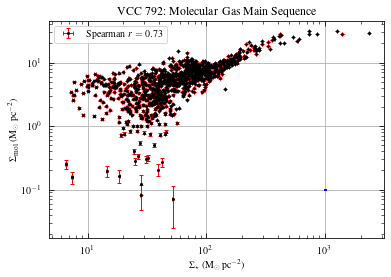

In [8]:
#
# Plot CO density vs stellar mass density
#
%matplotlib inline
plt.close("all")
# 
# Calculate Spearman correlation coefficient
# 
spearman_corr = spearmanr(M_density[data_co > 0], data_co[data_co > 0])
print(spearman_corr)
#
# Plot
#
fig, ax1 = plt.subplots()
ebar1 = ax1.errorbar(
    x=M_density[data_co > 0],
    y=data_co[data_co > 0],
    xerr=M_density_err_noDistErr[data_co > 0],
    yerr=unc_co_noDistErr[data_co > 0],
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
    label=f"Spearman $r = {spearman_corr[0]:.2f}$"
)
ebar1[-1][0].set_linestyle("-")
ax1.set_ylabel(r"$\rm \Sigma_{mol}$ ($\rm M_\odot\; pc^{-2}$)")
ax1.set_title("VCC 792: Molecular Gas Main Sequence")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$\rm \Sigma_{\star}$ ($\rm M_\odot\; pc^{-2}$)")
# Add scalebar for systematic error
sys_err_x_mean = np.mean(abs(abs(M_density_err_withDistErr[data_co > 0]) - abs(M_density_err_noDistErr[data_co > 0])))
sys_err_x_med = np.median(abs(abs(M_density_err_withDistErr[data_co > 0]) - abs(M_density_err_noDistErr[data_co > 0])))
sys_err_y_mean = np.mean(abs(unc_co_withDistErr[data_co > 0] - unc_co_noDistErr[data_co > 0]))
sys_err_y_med = np.median(abs(unc_co_withDistErr[data_co > 0] - unc_co_noDistErr[data_co > 0]))
print("Mean x diff b/w withDistErr and noDistErr:", sys_err_x_mean)
print("Median x diff b/w withDistErr and noDistErr:", sys_err_x_med)
print("Mean y diff b/w withDistErr and noDistErr:", sys_err_y_mean)
print("Median y diff b/w withDistErr and noDistErr:", sys_err_y_med)
print("Mean x withDistErr:", np.mean(abs(M_density_err_withDistErr[data_co > 0])))
print("Median x withDistErr:", np.median(abs(M_density_err_withDistErr[data_co > 0])))
print("Mean x noDistErr:", np.mean(abs(M_density_err_noDistErr[data_co > 0])))
print("Median x noDistErr:", np.median(abs(M_density_err_noDistErr[data_co > 0])))
scalebar_start = 1e3
scalebar_y = 1e-1
ax1.plot([scalebar_start, scalebar_start + sys_err_x_med], [scalebar_y] * 2, "b-", linewidth=2)
# ax1.hlines(scalebar_y, scalebar_start, scalebar_start + sys_err_med, "r", linewidth=2)
# ax1.set_xscale("log")
# ax1.set_yscale("log")
sys_err_str = "\n".join(
    (fr"Median $x$ Systematic Error: {{{sys_err_x_med:.0f}}} $\rm M_\odot\; pc^{{-2}}$",
    fr"Median $y$ Systematic Error: {{{sys_err_y_med:.2f}}} $\rm M_\odot\; pc^{{-2}}$",)
)
txt_props = {
    "boxstyle": "round",
    "facecolor": "w",
    "edgecolor": to_rgba("k", 0.5),
    "lw": 0.5,
    "alpha": None,
    "pad": 0.5,
}
# txt_props = {"fancybox": True, "facecolor": "w", "frameon": True}
# ax1.text(0.8e2, 3e-1, sys_err_str, verticalalignment='top', bbox=txt_props)
ax1.loglog()
# ax1.set_aspect("equal")
# fig.savefig("imgs/vcc792_MGMS_loglog_v2.1.pdf")
plt.show()

## Better version


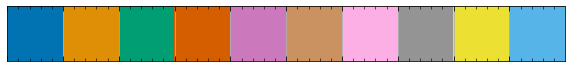

In [7]:
sns.palplot(sns.color_palette("colorblind"))
line_colour = sns.color_palette("colorblind")[5]

sig_int:     0.0000   1464.5293
Computing sig_int
sig_int:     0.0000   1464.5293
sig_int:     0.2661     -0.6303
sig_int:     0.2660     -0.6300
sig_int:     0.1330      0.4780
sig_int:     0.1904     -0.2779
sig_int:     0.1693     -0.0870
sig_int:     0.1611      0.0073
sig_int:     0.1618     -0.0005
sig_int:     0.1617      0.0005
Computing sig_int error
sig_int:     0.1617      0.0471
sig_int:     0.2661     -0.5838
sig_int:     0.1695     -0.0427
sig_int:     0.1658     -0.0016
sig_int:     0.1656      0.0000
Repeat at best fitting solution
sig_int:     0.1617      0.0005
################# Values and formal errors ################
 intercept:  0.7492 +/- 0.0053
     slope:  0.506 +/- 0.015
   scatter:  0.1617 +/- 0.0039
Observed rms scatter: 0.16
y = a + b*(x - pivot) with pivot = 1.738
Spearman r=0.73 and p=1.8e-168
Pearson r=0.64 and p=8.1e-117
##########################################################
seconds 62.03


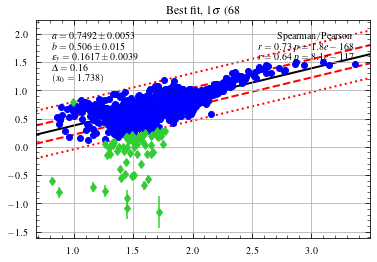

In [21]:
# 
# LTS fitting
# 
%matplotlib inline
pivot = np.median(np.log10(M_density[data_co > 0]))
clip = 2.6
popt = lts_linefit(
    np.log10(M_density[data_co > 0]),
    np.log10(data_co[data_co > 0]),
    M_density_err_noDistErr[data_co > 0] / (M_density[data_co > 0] * np.log(10)),
    unc_co_noDistErr[data_co > 0] / (data_co[data_co > 0] * np.log(10)),
    clip=clip,
    epsy=True,
    corr=True,
    frac=None,
    pivot=pivot,
    plot=True,
    text=True,
)
yint, slope = popt.ab
yint_err, slope_err = popt.ab_err
rms = popt.rms

In [9]:
print(popt.ab)
print(popt.ab_err)
# print(popt.mask)
print(popt.rms)
print(popt.sig_int)
print(popt.sig_int_err)

[0.74919979 0.5057936 ]
[0.00532905 0.01528306]
0.16184501890593017
0.16169765164775748
0.003947615397281196


In [49]:
#
# Plot CO density vs stellar mass density (log-values)
#
%matplotlib widget
# plt.close("all")
# 
# Calculate Spearman correlation coefficient
# 
spearman_corr = spearmanr(np.log10(M_density[data_co > 0]), np.log10(data_co[data_co > 0]))
print(spearman_corr)
#
# Plot
#
fig, ax1 = plt.subplots()
ebar1 = ax1.errorbar(
    x=np.log10(M_density[data_co > 0]),
    y=np.log10(data_co[data_co > 0]),
    # xerr=0.434 * M_density_err_noDistErr[data_co > 0] / M_density[data_co > 0],
    # yerr=0.434 * unc_co_noDistErr[data_co > 0] / data_co[data_co > 0],
    xerr=M_density_err_noDistErr[data_co > 0] / (M_density[data_co > 0] * np.log(10)),
    yerr=unc_co_noDistErr[data_co > 0] / (data_co[data_co > 0] * np.log(10)),
    fmt=".",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
    label=f"Spearman $r = {spearman_corr[0]:.2f}$"
)
ebar1[-1][0].set_linestyle("-")
ax1.set_ylabel(r"$\rm \log(\Sigma_{mol})$ ($\rm M_\odot\; pc^{-2}$)")
ax1.set_title("VCC 792: Molecular Gas Main Sequence")
ax1.legend(loc="best")
ax1.set_xlabel(r"$\rm \log(\Sigma_{\star})$ ($\rm M_\odot\; pc^{-2}$)")
# Add scalebar for systematic error
sys_err_x_mean = np.mean(abs(abs(np.log10(M_density_err_withDistErr[data_co > 0])) - abs(np.log10(M_density_err_noDistErr[data_co > 0]))))
sys_err_x_med = np.median(abs(abs(np.log10(M_density_err_withDistErr[data_co > 0])) - abs(np.log10(M_density_err_noDistErr[data_co > 0]))))
sys_err_y_mean = np.mean(abs(np.log10(unc_co_withDistErr[data_co > 0]) - np.log10(unc_co_noDistErr[data_co > 0])))
sys_err_y_med = np.median(abs(np.log10(unc_co_withDistErr[data_co > 0]) - np.log10(unc_co_noDistErr[data_co > 0])))
print("Mean x diff b/w withDistErr and noDistErr:", sys_err_x_mean)
print("Median x diff b/w withDistErr and noDistErr:", sys_err_x_med)
print("Mean y diff b/w withDistErr and noDistErr:", sys_err_y_mean)
print("Median y diff b/w withDistErr and noDistErr:", sys_err_y_med)
print("Mean x withDistErr:", np.mean(abs(M_density_err_withDistErr[data_co > 0])))
print("Median x withDistErr:", np.median(abs(M_density_err_withDistErr[data_co > 0])))
print("Mean x noDistErr:", np.mean(abs(M_density_err_noDistErr[data_co > 0])))
print("Median x noDistErr:", np.median(abs(M_density_err_noDistErr[data_co > 0])))
# ax1.set_aspect("equal")
# fig.savefig("imgs/vcc792_MGMS_logVals_errs.pdf")
plt.show()
# 
# KDE plot
# 
# fig, ax = plt.subplots()
# sns.jointplot(x=np.log10(M_density[data_co > 0]), y=np.log10(data_co[data_co > 0]), kind="kde")
# plt.show()
# 
fig, ax = plt.subplots()
sns.kdeplot(
    x=np.log10(M_density[data_co > 0]),
    y=np.log10(data_co[data_co > 0]),
    # cmap=sns.color_palette("ch:start=0.5, rot=-0.75", as_cmap=True),
    cmap=sns.color_palette("ch:start=0.5, rot=-0.5", as_cmap=True),
    # cbar=True,
    fill=True,
)
# ax.scatter(
#     np.log10(M_density[data_co > 0]),
#     np.log10(data_co[data_co > 0]),
#     s=4,
#     c="k",
#     marker="."
# )
# Plot LTS line
xvals = np.linspace(
    np.min(np.log10(M_density[data_co > 0])),
    # np.max(np.log10(M_density[data_co > 0])),
    3.0,
    100
)
linevals = slope * (xvals - pivot) + yint
ax.plot(xvals, linevals, color=line_colour, label="LTS")
ax.plot(xvals, linevals - rms, color=line_colour, ls="--", label="$1\sigma$")
ax.plot(xvals, linevals + rms, color=line_colour, ls="--")
ax.plot(xvals, linevals - clip * rms, color=line_colour, ls=":", label=f"${clip}\sigma$")
ax.plot(xvals, linevals + clip * rms, color=line_colour, ls=":")
ax.set_xlim(left=0.5)
ax.set_ylim(bottom=-0.5, top=2)
ax.set_title("VCC 792: Molecular Gas Main Sequence")
ax.set_xlabel(r"$\rm \log(\Sigma_{\star})$ ($\rm M_\odot\; pc^{-2}$)")
ax.set_ylabel(r"$\rm \log(\Sigma_{mol})$ ($\rm M_\odot\; pc^{-2}$)")
ax.legend(loc="best")
# fig.savefig("imgs/vcc792_MGMS_kde.pdf")
plt.show()

SpearmanrResult(correlation=0.7338916317415163, pvalue=1.8106956492162506e-168)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Mean x diff b/w withDistErr and noDistErr: 0.46309799008540664
Median x diff b/w withDistErr and noDistErr: 0.4044088380688166
Mean y diff b/w withDistErr and noDistErr: 1.0861542878150505
Median y diff b/w withDistErr and noDistErr: 1.1242948451905725
Mean x withDistErr: 19.32997879794601
Median x withDistErr: 13.39052494075861
Mean x noDistErr: 0.1940645810294447
Median x noDistErr: 0.180172455344208


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

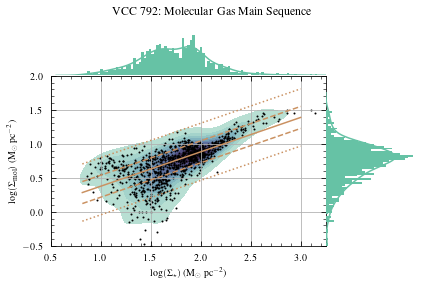

In [9]:
%matplotlib inline
# 
# Joint plot for MGMS
# 
grid = mpl.gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 4])
fig = plt.figure()
# Primary plot
ax = plt.subplot(grid[1, 0])
sns.kdeplot(
    ax=ax,
    x=np.log10(M_density[data_co > 0]),
    y=np.log10(data_co[data_co > 0]),
    # cmap=sns.color_palette("ch:start=0.5, rot=-0.75", as_cmap=True),
    cmap=sns.color_palette("ch:start=0.5, rot=-0.5", as_cmap=True),
    # cbar=True,
    fill=True,
)
ax.scatter(
    np.log10(M_density[data_co > 0]),
    np.log10(data_co[data_co > 0]),
    s=4,
    c="k",
    marker="."
)
# Plot LTS line (slope, yint, rms, clip, and pivot from LTS fit)
xvals = np.linspace(
    np.min(np.log10(M_density[data_co > 0])),
    # np.max(np.log10(M_density[data_co > 0])),
    3.0,
    100
)
linevals = slope * (xvals - pivot) + yint
ax.plot(xvals, linevals, color=line_colour, label="LTS")
ax.plot(xvals, linevals - rms, color=line_colour, ls="--", label="$1\sigma$")
ax.plot(xvals, linevals + rms, color=line_colour, ls="--")
ax.plot(xvals, linevals - clip * rms, color=line_colour, ls=":", label=f"${clip}\sigma$")
ax.plot(xvals, linevals + clip * rms, color=line_colour, ls=":")
ax.set_xlim(0.5, 3.25)
ax.set_ylim(0.5, 2)
ax.set_xlabel(r"$\rm \log(\Sigma_{\star})$ ($\rm M_\odot\; pc^{-2}$)")
ax.set_ylabel(r"$\rm \log(\Sigma_{mol})$ ($\rm M_\odot\; pc^{-2}$)")
# ax.legend(loc="best")
ax.grid(True)
# Right marginal plot
ax_r = plt.subplot(grid[1, 1], frameon=False, sharey=ax, xticks=[])
ax_r.hist(np.log10(data_co[data_co > 0]), bins=100, orientation="horizontal", density=True)
sns.kdeplot(y=np.log10(data_co[data_co > 0]), ax=ax_r, fill=False, color="C0")
ax_r.yaxis.set_ticks_position("none")
plt.setp(ax_r.get_yticklabels(), visible=False)
ax_r.grid(False)
# Top marginal plot
ax_t = plt.subplot(grid[0, 0], frameon=False, sharex=ax, yticks=[])
ax_t.hist(np.log10(M_density[data_co > 0].value), bins=100, orientation="vertical", density=True)
sns.kdeplot(x=np.log10(M_density[data_co > 0]), ax=ax_t, fill=False, color="C0")
ax_t.xaxis.set_ticks_position("none")
plt.setp(ax_t.get_xticklabels(), visible=False)
ax_t.grid(False)
# 
fig.suptitle("VCC 792: Molecular Gas Main Sequence")
fig.tight_layout()
plt.subplots_adjust(wspace=2e-3, hspace=4e-3)
# fig.savefig("imgs/vcc792_MGMS_kde_v1.1.pdf")
plt.show()

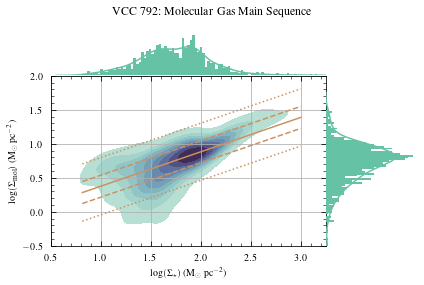

In [20]:
# 
# Reference code snippet for others
# 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# 
xdata = np.log10(M_density[data_co > 0]).value
ydata = np.log10(data_co[data_co > 0])
line_colour = sns.color_palette("colorblind")[5]
# 
# Joint plot for MGMS
# 
grid = mpl.gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 4])
fig = plt.figure()
# 
# Primary plot
# 
ax = plt.subplot(grid[1, 0])
# Plot KDE contours
sns.kdeplot(
    ax=ax,
    x=xdata,
    y=ydata,
    cmap=sns.color_palette("ch:start=0.5, rot=-0.5", as_cmap=True),  # cubehelix colours
    # https://seaborn.pydata.org/tutorial/color_palettes.html#sequential-cubehelix-palettes
    fill=True,
)
# Plot LTS line (slope, yint, rms, clip, and pivot from LTS fit)
xvals = np.linspace(np.min(xdata), 3.0, 100)
linevals = slope * (xvals - pivot) + yint
ax.plot(xvals, linevals, color=line_colour)                       # best-fit line  
ax.plot(xvals, linevals - rms, color=line_colour, ls="--")        # 68% range
ax.plot(xvals, linevals + rms, color=line_colour, ls="--")
ax.plot(xvals, linevals - clip * rms, color=line_colour, ls=":")  # 99% range
ax.plot(xvals, linevals + clip * rms, color=line_colour, ls=":")
ax.set_xlim(0.5, 3.25)
ax.set_ylim(-0.5, 2)
ax.set_xlabel(r"$\rm \log(\Sigma_{\star})$ ($\rm M_\odot\; pc^{-2}$)")
ax.set_ylabel(r"$\rm \log(\Sigma_{mol})$ ($\rm M_\odot\; pc^{-2}$)")
ax.grid(True)
# 
# Right marginal plot
# 
ax_r = plt.subplot(grid[1, 1], frameon=False, sharey=ax, xticks=[])
ax_r.hist(ydata, bins=100, orientation="horizontal", density=True)
sns.kdeplot(y=ydata, ax=ax_r, fill=False, color="C0")
ax_r.yaxis.set_ticks_position("none")
plt.setp(ax_r.get_yticklabels(), visible=False)
ax_r.grid(False)
# 
# Top marginal plot
# 
ax_t = plt.subplot(grid[0, 0], frameon=False, sharex=ax, yticks=[])
ax_t.hist(xdata, bins=100, orientation="vertical", density=True)
sns.kdeplot(x=xdata, ax=ax_t, fill=False, color="C0")
ax_t.xaxis.set_ticks_position("none")
plt.setp(ax_t.get_xticklabels(), visible=False)
ax_t.grid(False)
# 
# Other plot params
# 
fig.suptitle("VCC 792: Molecular Gas Main Sequence")
fig.tight_layout()
plt.subplots_adjust(wspace=2e-3, hspace=4e-3)
plt.show()

# Gas Fraction Map


In [ ]:
%matplotlib widget
plt.close("all")
# 
# Make 2D plot of stellar mass density to CO density ratio
# Q: at the same gas density, why do some pixels have higher stellar mass densities than
# others? What is the distinguishing factor?
# 
# Some data_co elements < 0...
mass_per_co = abs(M_density / data_co)  # Stellar mass density per CO surface density
fig, ax = plt.subplots(subplot_kw={"projection": i_wcs})
img = ax.imshow(mass_per_co, cmap="Blues", vmin=0, vmax=40)
cbar = fig.colorbar(img, ax=ax)
cbar.set_label(r"$\rm \Sigma_{\star} / \Sigma_{mol}$")
ax.set_title("Ratio of Stellar Mass Density to H$_2$ Density")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
# fig.savefig("imgs/vcc792_mass_CO_ratio.pdf")
plt.show()
# 
# Make plot of gas fraction throughout galaxy
# 
# Some data_co elements < 0...
gas_frac = np.log10(
    abs(
        np.ma.masked_where(data_co == 0, data_co)
        / np.ma.masked_where(data_co == 0, M_density)
    )
)
fig, ax = plt.subplots(subplot_kw={"projection": i_wcs})
# img = ax.imshow(gas_frac, cmap="Blues", vmin=0, vmax=0.25)
# img = ax.imshow(gas_frac, cmap="Blues", vmin=None, vmax=np.percentile(gas_frac, 98))
img = ax.imshow(gas_frac, cmap="Blues", vmin=None, vmax=-0.5)
cbar = fig.colorbar(img, ax=ax)
cbar.set_label(r"Gas Fraction: $\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
ax.set_title("VCC 792: Gas Fraction Map")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
# fig.savefig("imgs/vcc792_gas_frac_9as_log.pdf")
plt.show()